In [2]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [25]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor()           # 转换为张量
])

train_dataset = datasets.ImageFolder(root='C:/Users/m1522/Desktop/Working/CS4487gp/AIGC-Detection-Dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='C:/Users/m1522/Desktop/Working/CS4487gp/AIGC-Detection-Dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 29 * 29, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 2)  # Assuming 32 categories for classification

    def forward(self, t):
        t = self.pool(F.relu(self.conv1(t)))
        t = self.pool(F.relu(self.conv2(t)))
        t = t.view(-1, 64 * 29 * 29)  # Adjusted size
        t = F.relu(self.fc1(t))
        t = self.fc2(t)
        return t

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total
    return running_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return running_loss / len(dataloader), accuracy

In [27]:
model = Network()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
from tqdm import tqdm

num_epochs = 30
best_accuracy = 0.0
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Append accuracies for plotting
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        print("Best model!")

print("Training complete. Best validation accuracy: {:.4f}".format(best_accuracy))



Epoch 1/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.41it/s]


Train Loss: 0.5351, Train Accuracy: 0.7352, Val Loss: 0.4667, Val Accuracy: 0.7796
Best model!
Epoch 2/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.45it/s]


Train Loss: 0.4508, Train Accuracy: 0.7913, Val Loss: 0.4479, Val Accuracy: 0.7912
Best model!
Epoch 3/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:03<00:00,  2.47it/s]


Train Loss: 0.4202, Train Accuracy: 0.8081, Val Loss: 0.4504, Val Accuracy: 0.7876
Epoch 4/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:03<00:00,  2.46it/s]


Train Loss: 0.3443, Train Accuracy: 0.8478, Val Loss: 0.4934, Val Accuracy: 0.7906
Epoch 5/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.29it/s]


Train Loss: 0.2141, Train Accuracy: 0.9136, Val Loss: 0.6220, Val Accuracy: 0.7660
Epoch 6/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.41it/s]


Train Loss: 0.1026, Train Accuracy: 0.9630, Val Loss: 0.9989, Val Accuracy: 0.7530
Epoch 7/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.43it/s]


Train Loss: 0.0609, Train Accuracy: 0.9813, Val Loss: 1.1700, Val Accuracy: 0.7600
Epoch 8/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.43it/s]


Train Loss: 0.0397, Train Accuracy: 0.9871, Val Loss: 1.3718, Val Accuracy: 0.7502
Epoch 9/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.38it/s]


Train Loss: 0.0379, Train Accuracy: 0.9897, Val Loss: 1.6327, Val Accuracy: 0.7560
Epoch 10/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:04<00:00,  2.43it/s]


Train Loss: 0.0258, Train Accuracy: 0.9918, Val Loss: 1.6106, Val Accuracy: 0.7580
Epoch 11/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]


Train Loss: 0.0233, Train Accuracy: 0.9930, Val Loss: 1.6924, Val Accuracy: 0.7600
Epoch 12/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]


Train Loss: 0.0245, Train Accuracy: 0.9932, Val Loss: 1.9585, Val Accuracy: 0.7594
Epoch 13/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.31it/s]


Train Loss: 0.0195, Train Accuracy: 0.9950, Val Loss: 1.9589, Val Accuracy: 0.7556
Epoch 14/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.39it/s]


Train Loss: 0.0149, Train Accuracy: 0.9956, Val Loss: 2.1865, Val Accuracy: 0.7600
Epoch 15/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:03<00:00,  2.47it/s]


Train Loss: 0.0141, Train Accuracy: 0.9964, Val Loss: 2.1459, Val Accuracy: 0.7616
Epoch 16/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]


Train Loss: 0.0215, Train Accuracy: 0.9945, Val Loss: 2.0992, Val Accuracy: 0.7450
Epoch 17/30


Validation: 100%|████████████████████████████████████████████████████████████████████| 157/157 [01:03<00:00,  2.49it/s]


Train Loss: 0.0152, Train Accuracy: 0.9960, Val Loss: 2.1804, Val Accuracy: 0.7598
Epoch 18/30


Validation:   0%|                                                                              | 0/157 [00:15<?, ?it/s]


KeyboardInterrupt: 

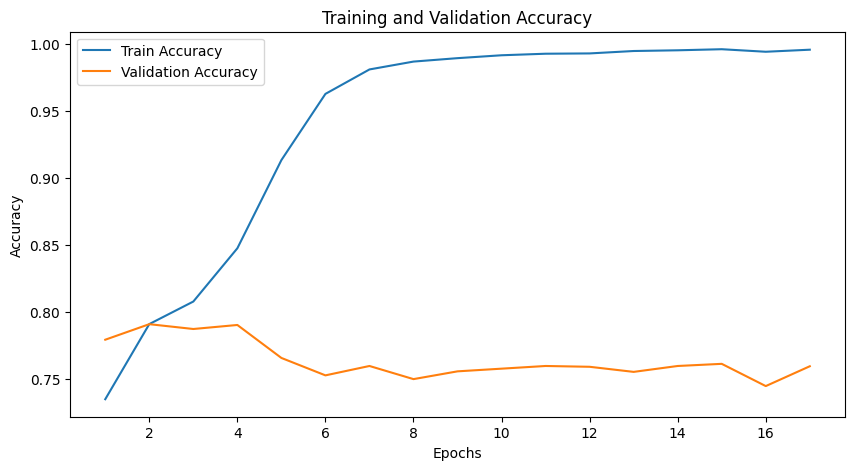

In [30]:
import matplotlib.pyplot as plt
# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 17 + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 17 + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
